In [89]:
import os
import cv2
import torch
import numpy as np
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [90]:
import sys
import time
_initial_missing = object()
def reduce(function, sequence, initial=_initial_missing):
    """
    reduce(function, iterable[, initial]) -> value

    Apply a function of two arguments cumulatively to the items of a sequence
    or iterable, from left to right, so as to reduce the iterable to a single
    value.  For example, reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates
    ((((1+2)+3)+4)+5).  If initial is present, it is placed before the items
    of the iterable in the calculation, and serves as a default when the
    iterable is empty.
    """

    it = iter(sequence)

    if initial is _initial_missing:
        try:
            value = next(it)
        except StopIteration:
            raise TypeError(
                "reduce() of empty iterable with no initial value") from None
    else:
        value = initial

    for element in it:
        value = function(value, element)

    return value
def _axis_angle_rotation(axis: str, angle):
    """
    Return the rotation matrices for one of the rotations about an axis
    of which Euler angles describe, for each value of the angle given.

    Args:
        axis: Axis label "X" or "Y or "Z".
        angle: any shape tensor of Euler angles in radians

    Returns:
        Rotation matrices as tensor of shape (..., 3, 3).
    """

    cos = torch.cos(angle)
    sin = torch.sin(angle)
    one = torch.ones_like(angle)
    zero = torch.zeros_like(angle)

    if axis == "X":
        R_flat = (one, zero, zero, zero, cos, -sin, zero, sin, cos)
    if axis == "Y":
        R_flat = (cos, zero, sin, zero, one, zero, -sin, zero, cos)
    if axis == "Z":
        R_flat = (cos, -sin, zero, sin, cos, zero, zero, zero, one)

    return torch.stack(R_flat, -1).reshape(angle.shape + (3, 3))

def euler_angles_to_matrix(euler_angles, convention: str):
    """
    Convert rotations given as Euler angles in radians to rotation matrices.

    Args:
        euler_angles: Euler angles in radians as tensor of shape (..., 3).
        convention: Convention string of three uppercase letters from
            {"X", "Y", and "Z"}.

    Returns:
        Rotation matrices as tensor of shape (..., 3, 3).
    """
    if euler_angles.dim() == 0 or euler_angles.shape[-1] != 3:
        raise ValueError("Invalid input euler angles.")
    if len(convention) != 3:
        raise ValueError("Convention must have 3 letters.")
    if convention[1] in (convention[0], convention[2]):
        raise ValueError(f"Invalid convention {convention}.")
    for letter in convention:
        if letter not in ("X", "Y", "Z"):
            raise ValueError(f"Invalid letter {letter} in convention string.")
    matrices = map(_axis_angle_rotation, convention, torch.unbind(euler_angles, -1))
    return reduce(torch.matmul, matrices)

def get_BEV_projection(img, Ho, Wo, Fov=170, dty=-20, dx=0, dy=0, device = 'cpu'):
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = device

    Hp, Wp = img.shape[0], img.shape[1]  # Panorama image dimensions

    Fov = Fov * torch.pi / 180  # Field of View in radians
    center = torch.tensor([Wp / 2 + dx, Hp + dy]).to(device)  # Overhead view center

    anglex = torch.tensor(dx).to(device) * 2 * torch.pi / Wp
    angley = -torch.tensor(dy).to(device) * torch.pi / Hp
    anglez = torch.tensor(0).to(device)

    # Euler angles
    euler_angles = (anglex, angley, anglez)
    euler_angles = torch.stack(euler_angles, -1)

    # Calculate the rotation matrix
    R02 = euler_angles_to_matrix(euler_angles, "XYZ")
    R20 = torch.inverse(R02)

    f = Wo / 2 / torch.tan(torch.tensor(Fov / 2))
    out = torch.zeros((Wo, Ho, 2)).to(device)
    f0 = torch.zeros((Wo, Ho, 3)).to(device)
    f0[:, :, 0] = Ho / 2 - (torch.ones((Ho, Wo)).to(device) * (torch.arange(Ho)).to(device)).T
    f0[:, :, 1] = Wo / 2 - torch.ones((Ho, Wo)).to(device) * torch.arange(Wo).to(device)
    f0[:, :, 2] = -torch.ones((Wo, Ho)).to(device) * f
    f1 = R20 @ f0.reshape((-1, 3)).T  # x, y, z (3, N)
    f1_0 = torch.sqrt(torch.sum(f1**2, 0))
    f1_1 = torch.sqrt(torch.sum(f1[:2, :]**2, 0))
    theta = torch.arctan2(f1[2, :], f1_1) + torch.pi / 2  # [-pi/2, pi/2] => [0, pi]
    phi = torch.arctan2(f1[1, :], f1[0, :])  # [-pi, pi]
    phi = phi + torch.pi  # [0, 2pi]

    i_p = 1 - theta / torch.pi  # [0, 1]
    j_p = 1 - phi / (2 * torch.pi)  # [0, 1]
    out[:, :, 0] = j_p.reshape((Ho, Wo))
    out[:, :, 1] = i_p.reshape((Ho, Wo))
    out[:, :, 0] = (out[:, :, 0] - 0.5) / 0.5  # [-1, 1]
    out[:, :, 1] = (out[:, :, 1] - 0.5) / 0.5  # [-1, 1]

    return out


def get_BEV_tensor(img, Ho, Wo, Fov=170, dty=-20, dx=0, dy=0, dataset=False, out=None, device = 'cpu'):
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = device
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()

    t0 = time.time()
    Hp, Wp = img.shape[0], img.shape[1]  # Panorama image dimensions
    if dty != 0 or Wp != 2 * Hp:
        ty = (Wp / 2 - Hp) / 2 + dty  # Non-standard panorama image completion
        matrix_K = np.array([[1, 0, 0], [0, 1, ty], [0, 0, 1]])
        img = cv2.warpPerspective(img, matrix_K, (int(Wp), int(Hp + (Wp / 2 - Hp))))
    ######################
    t1 = time.time()
    # frame = torch.from_numpy(img.astype(np.float32)).to(device)
    frame = torch.from_numpy(img.copy()).to(device)
    t2 = time.time()

    if out is None:
        Fov = Fov * torch.pi / 180  # Field of View in radians
        center = torch.tensor([Wp / 2 + dx, Hp + dy]).to(device)  # Overhead view center

        anglex = torch.tensor(dx).to(device) * 2 * torch.pi / Wp
        angley = -torch.tensor(dy).to(device) * torch.pi / Hp
        anglez = torch.tensor(0).to(device)

        # Euler angles
        euler_angles = (anglex, angley, anglez)
        euler_angles = torch.stack(euler_angles, -1)

        # Calculate the rotation matrix
        R02 = euler_angles_to_matrix(euler_angles, "XYZ")
        R20 = torch.inverse(R02)

        f = Wo / 2 / torch.tan(torch.tensor(Fov / 2))
        out = torch.zeros((Wo, Ho, 2)).to(device)
        f0 = torch.zeros((Wo, Ho, 3)).to(device)
        f0[:, :, 0] = Ho / 2 - (torch.ones((Ho, Wo)).to(device) * (torch.arange(Ho)).to(device)).T
        f0[:, :, 1] = Wo / 2 - torch.ones((Ho, Wo)).to(device) * torch.arange(Wo).to(device)
        f0[:, :, 2] = -torch.ones((Wo, Ho)).to(device) * f
        f1 = R20 @ f0.reshape((-1, 3)).T  # x, y, z (3, N)
        # f1 = f0.reshape((-1, 3)).T
        f1_0 = torch.sqrt(torch.sum(f1**2, 0))
        f1_1 = torch.sqrt(torch.sum(f1[:2, :]**2, 0))
        theta = torch.arctan2(f1[2, :], f1_1) + torch.pi / 2  # [-pi/2, pi/2] => [0, pi]
        phi = torch.arctan2(f1[1, :], f1[0, :])  # [-pi, pi]
        phi = phi + torch.pi  # [0, 2pi]

        i_p = 1 - theta / torch.pi  # [0, 1]
        j_p = 1 - phi / (2 * torch.pi)  # [0, 1]
        out[:, :, 0] = j_p.reshape((Ho, Wo))
        out[:, :, 1] = i_p.reshape((Ho, Wo))
        out[:, :, 0] = (out[:, :, 0] - 0.5) / 0.5  # [-1, 1]
        out[:, :, 1] = (out[:, :, 1] - 0.5) / 0.5  # [-1, 1]
    # else:
    #     out = out.to(device)
    t3 = time.time()

    BEV = F.grid_sample(frame.permute(2, 0, 1).unsqueeze(0).float(), out.unsqueeze(0), align_corners=True)
    t4 = time.time()
    # print("Read image ues {:.2f} ms, warpPerspective image use {:.2f} ms, Get matrix ues {:.2f} ms, Get out ues {:.2f} ms, All out ues {:.2f} ms.".format((t1-t0)*1000,(t2-t1)*1000, (t3-t2)*1000,(t4-t3)*1000,(t4-t0)*1000))
    if dataset:
        return BEV.squeeze(0)
    else:
        return BEV.permute(0, 2, 3, 1).squeeze(0).int()

In [95]:
# Function to process each image and apply BEV transformation
def process_image(img_path, target_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    out = get_BEV_projection(img, 224, 224, Fov=170, dty=0, dx=0, dy=-10)
    BEV = get_BEV_tensor(img, 224, 224, Fov=85*2, dty=0, dx=0, dy=0, out=out)

        # Convert tensor back to numpy array and then to BGR for OpenCV
    BEV_image = BEV.cpu().numpy().astype(np.uint8)
    plt.imshow(BEV_image)
    # Save the transformed image
    joined_image = np.concatenate((img, BEV_image), axis=1)
    joined_image.astype(np.uint8)
    joined_image_show = cv2.cvtColor(joined_image, cv2.COLOR_RGB2BGR)
    plt.imshow(joined_image_show)
    print(joined_image.shape)
    cv2.imwrite(target_path, joined_image)



In [96]:
img_path = 'D:\\CVGL\\CVPR_subset\\streetview\\panos\\0000001.jpg'
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"Failed to load image from {img_path}")

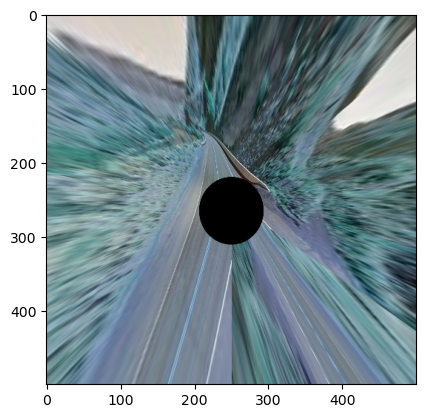

In [97]:
out = get_BEV_projection(img, 500, 500, Fov=170, dty=0, dx=0, dy=-10)
BEV = get_BEV_tensor(img, 224, 224, Fov=85*2, dty=0, dx=0, dy=0, out=out)

    # Convert tensor back to numpy array and then to BGR for OpenCV
BEV_image = BEV.cpu().numpy().astype(np.uint8)
plt.imshow(BEV)

(224, 1680, 3)


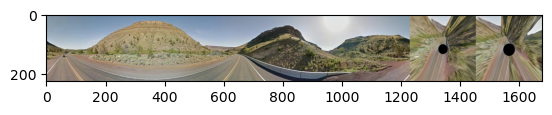

In [98]:
process_image('D:\\CVGL\\CVPR_subset\\streetview\\panos\\0000001.jpg','D:\\CVGL\\CVPR_subset\\streetview\\panos_bev\\0000001.jpg')

Progress: 0.00% (1/44516)
Progress: 0.00% (2/44516)
Progress: 0.01% (3/44516)
Progress: 0.01% (4/44516)
Progress: 0.01% (5/44516)
Progress: 0.01% (6/44516)
Progress: 0.02% (7/44516)
Progress: 0.02% (8/44516)
Progress: 0.02% (9/44516)
Progress: 0.02% (10/44516)
Progress: 0.02% (11/44516)
Progress: 0.03% (12/44516)
Progress: 0.03% (13/44516)
Progress: 0.03% (14/44516)
Progress: 0.03% (15/44516)
Progress: 0.04% (16/44516)
Progress: 0.04% (17/44516)
Progress: 0.04% (18/44516)
Progress: 0.04% (19/44516)
Progress: 0.04% (20/44516)
Progress: 0.05% (21/44516)
Progress: 0.05% (22/44516)
Progress: 0.05% (23/44516)
Progress: 0.05% (24/44516)
Progress: 0.06% (25/44516)
Progress: 0.06% (26/44516)
Progress: 0.06% (27/44516)
Progress: 0.06% (28/44516)
Progress: 0.07% (29/44516)
Progress: 0.07% (30/44516)
Progress: 0.07% (31/44516)
Progress: 0.07% (32/44516)
Progress: 0.07% (33/44516)
Progress: 0.08% (34/44516)
Progress: 0.08% (35/44516)
Progress: 0.08% (36/44516)
Progress: 0.08% (37/44516)
Progress: 

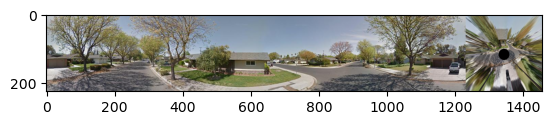

In [88]:
source_dir = 'D:\\CVGL\\CVPR_subset\\streetview\\panos'
target_dir = 'D:\\CVGL\\CVPR_subset\\streetview\\panos_bev'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Get a list of files to process
files = os.listdir(source_dir)
total_files = len(files)

# Process each image in the source directory
for i, filename in enumerate(files, start=1):
    img_path = os.path.join(source_dir, filename)
    target_path = os.path.join(target_dir, filename)
    process_image(img_path, target_path)
    
    # Print the progress as a percentage
    print(f"Progress: {i/total_files*100:.2f}% ({i}/{total_files})")

print("All images have been processed and saved.")

In [109]:
import socket

def check_port(ip, port):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        return s.connect_ex((ip, port)) == 0

# Replace 'localhost' and '10001' with your dist_url's IP and port
ip = 'localhost'
port = 10001
if check_port(ip, port):
    print(f"Port {port} is open.")
else:
    print(f"Port {port} is closed or not accessible.")


Port 10001 is closed or not accessible.


In [125]:
!python -u train.py --lr 0.0001 --batch-size 32  --world-size 1 --rank 0  --epochs 100 --save_path ./result --op sam --wd 0.03 --mining --dataset cvusa --cos --dim 1000 --asam --rho 2.5

^C


d:\CVGL\TransGeo2022\model\Deit.py:140: UserWarning: Overwriting deit_small_distilled_patch16_224 in registry with model.Deit.deit_small_distilled_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
c:\Users\abhilash.durgam\.conda\envs\TransGeo1\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 20 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
d:\CVGL\TransGeo2022\model\Deit.py:140: UserWarning: Overwriting deit_small_distilled_patch16_224 in registry with model.Deit.deit_small_distilled_patch16_224. This is be

Namespace(workers=32, epochs=100, start_epoch=0, batch_size=32, lr=0.0001, schedule=[120, 160], momentum=0.9, weight_decay=0.03, print_freq=10, resume='', save_path='./result', world_size=1, rank=0, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=None, gpu=None, multiprocessing_distributed=False, evaluate=False, dim=1000, cos=True, cross=False, dataset='cvusa', op='sam', share=False, mining=True, asam=True, rho=2.5, sat_res=0, crop=False, fov=0)
=> creating model '{}'
module.query_net.cls_token
module.query_net.pos_embed
module.query_net.dist_token
module.query_net.patch_embed.proj.weight
module.query_net.patch_embed.proj.bias
module.query_net.blocks.0.norm1.weight
module.query_net.blocks.0.norm1.bias
module.query_net.blocks.0.attn.qkv.weight
module.query_net.blocks.0.attn.qkv.bias
module.query_net.blocks.0.attn.proj.weight
module.query_net.blocks.0.attn.proj.bias
module.query_net.blocks.0.norm2.weight
module.query_net.blocks.0.norm2.bias
module.query_net.blocks.0.mlp.fc